<a href="https://colab.research.google.com/github/stxupengyu/NCF-MF-for-Recommendation/blob/main/yelp_nn_recomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Link Google Drive

In [1]:
#link google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#enter the folder
!ls
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dataset@Yelp')
!ls

drive  sample_data
best_model.h5		    rating_text.csv			 yelp_academic_dataset_checkin.json
business_data_subset.csv    test.csv				 yelp_academic_dataset_review.csv
Dataset_User_Agreement.pdf  train.csv				 yelp_academic_dataset_review.json
rating.csv		    yelp_academic_dataset_business.csv	 yelp_academic_dataset_tip.json
rating_review_emb.csv	    yelp_academic_dataset_business.json  yelp_academic_dataset_user.json


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv('rating_text.csv')
display(data.tail(2))

,user_id,business_id,stars,text
150853,68981,2703,1.0,I don't recommend ordering food from this rest...
150854,26444,2704,5.0,There aren't enough words I can say about how ...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150855 entries, 0 to 150854
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      150855 non-null  int64  
 1   business_id  150855 non-null  int64  
 2   stars        150855 non-null  float64
 3   text         150855 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 4.6+ MB


In [5]:
n_users, n_rests, max_rating = data.iloc[:,:3].max()
min_rating = data.iloc[:,2].min()
n_factors = 1000

In [6]:
from sklearn.model_selection import train_test_split

X = data[['user_id', 'business_id']].values
y = data['stars'].values

X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_keras.shape, X_test_keras.shape, y_train_keras.shape, y_test_keras.shape

((120684, 2), (30171, 2), (120684,), (30171,))

In [7]:
X_train_array = [X_train_keras[:, 0], X_train_keras[:, 1]]
X_test_array = [X_test_keras[:, 0], X_test_keras[:, 1]]

## NCF Baseline Model

In [ ]:
def Recommender(n_users, n_rests, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)

    restaurant = Input(shape=(1,))
    m = EmbeddingLayer(n_rests, n_factors)(restaurant)
    mb = EmbeddingLayer(n_rests, 1)(restaurant)

    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, restaurant], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae','mse'])

    return model


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint, EarlyStopping

#保存最好的模型
model_name='best_model.h5'
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath=model_name, monitor='val_loss', save_best_only=True)
keras_model = Recommender(int(n_users)+1, int(n_rests)+1, n_factors, min_rating, max_rating)
keras_model.summary()
history = keras_model.fit(x=X_train_array, y=y_train_keras, batch_size=64,\
      epochs=150, verbose=1, callbacks=[es, cp], validation_data=(X_test_array, y_test_keras))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 1000)              7790200   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 1000)              2705000   ['input_2[0][0]']         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1886/1886 [==============================] - 79s 40ms/step - loss: 2.1524 - mae: 1.3021 - mse: 2.1336 - val_loss: 1.9083 - val_mae: 1.1927 - val_mse: 1.8644
Epoch 2/150
1886/1886 [==============================] - 60s 32ms/step - loss: 0.5743 - mae: 0.5643 - mse: 0.5060 - val_loss: 1.9328 - val_mae: 1.1742 - val_mse: 1.8404
Epoch 3/150
1886/1886 [==============================] - 67s 36ms/step - loss: 0.3470 - mae: 0.3658 - mse: 0.2562 - val_loss: 1.8877 - val_mae: 1.1471 - val_mse: 1.7920
Epoch 4/150
1886/1886 [==============================] - 67s 35ms/step - loss: 0.3427 - mae: 0.3846 - mse: 0.2466 - val_loss: 1.8728 - val_mae: 1.1365 - val_mse: 1.7674
Epoch 5/150
1886/1886 [==============================] - 67s 35ms/step - loss: 0.3251 - mae: 0.3591 - mse: 0.2250 - val_loss: 1.8309 - val_mae: 1.1164 - val_mse: 1.7260
Epoch 6/150
1886/1886 [==============================] - 67s 35ms/step - loss: 0.3337 - mae: 0.3645 - mse: 0.2346 - val_loss: 1.8021 - val_mae: 1.1013 - val_mse: 1.698

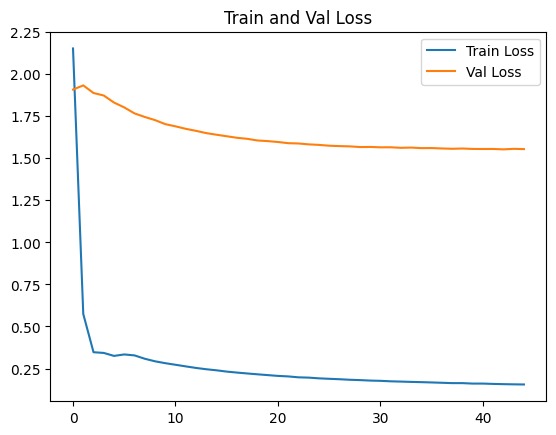

943/943 [==============================] - 1s 1ms/step
mae,rmse: 0.9540639224167328 1.2186206311359007


In [ ]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()
# 加载最好的训练结果
keras_model.load_weights(model_name)
y_pred = keras_model.predict(X_test_array)
mae = mean_absolute_error(y_test_keras, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_keras, y_pred))
print('mae,rmse:',mae,rmse)

# NeuMF Model

In [61]:
import tensorflow as tf
from keras.layers import Add, Activation, Lambda, Concatenate, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors

    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)

        return x

def NeuMF(n_users, n_rests, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)

    restaurant = Input(shape=(1,))
    m = EmbeddingLayer(n_rests, n_factors)(restaurant)

    # MF
    mf = Dot(axes=1)([u, m])

    # MLP
    mlp = Concatenate()([u, m])
    mlp = Dense(16, activation='relu')(mlp)
    mlp = BatchNormalization()(mlp)
    mlp = Dropout(0.2)(mlp)
    mlp = Dense(8, activation='relu')(mlp)
    mlp = BatchNormalization()(mlp)
    mlp = Dropout(0.2)(mlp)

    # Combine MF and MLP components
    x = Concatenate()([mf, mlp])
    x = Dense(8, activation='relu')(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, restaurant], outputs=x)
    opt = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae', 'mse'])

    return model

In [62]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint, EarlyStopping

#保存最好的模型
model_name='best_model.h5'
es = EarlyStopping(monitor='val_loss', patience=3)
cp = ModelCheckpoint(filepath=model_name, monitor='val_loss', save_best_only=True)
keras_model = NeuMF(int(n_users)+1, int(n_rests)+1, n_factors, min_rating, max_rating)
keras_model.summary()
history = keras_model.fit(x=X_train_array, y=y_train_keras, batch_size=64,\
      epochs=150, verbose=1, callbacks=[es, cp], validation_data=(X_test_array, y_test_keras))


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_36 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_50 (Embedding)    (None, 1, 1000)              7790200   ['input_35[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_51 (Embedding)    (None, 1, 1000)              2705000   ['input_36[0][0]']     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1886/1886 [==============================] - 71s 36ms/step - loss: 1.6818 - mae: 1.0508 - mse: 1.6653 - val_loss: 1.5630 - val_mae: 0.9910 - val_mse: 1.5274
Epoch 2/150
1886/1886 [==============================] - 64s 34ms/step - loss: 1.0008 - mae: 0.7311 - mse: 0.9455 - val_loss: 1.7656 - val_mae: 1.0266 - val_mse: 1.6883
Epoch 3/150
1886/1886 [==============================] - 63s 34ms/step - loss: 0.5750 - mae: 0.5176 - mse: 0.4947 - val_loss: 1.6471 - val_mae: 0.9774 - val_mse: 1.5609
Epoch 4/150
1886/1886 [==============================] - 63s 34ms/step - loss: 0.3090 - mae: 0.3449 - mse: 0.2242 - val_loss: 1.6603 - val_mae: 0.9986 - val_mse: 1.5748


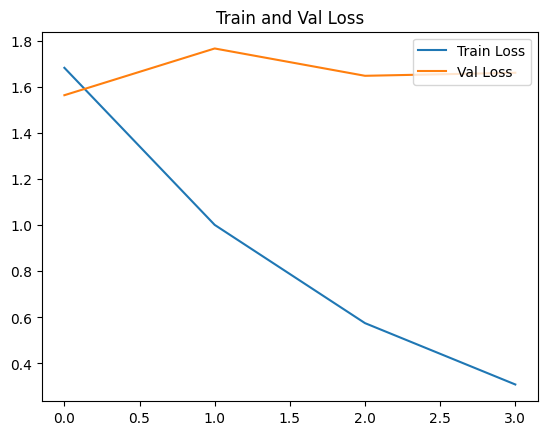

943/943 [==============================] - 2s 2ms/step
mae,rmse: 0.9909740253176144 1.235873070275169


In [63]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()
# 加载最好的训练结果
keras_model.load_weights(model_name)
y_pred = keras_model.predict(X_test_array)
mae = mean_absolute_error(y_test_keras, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_keras, y_pred))
print('mae,rmse:',mae,rmse)

In [13]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.1 MB/s eta 0:00:00


# DeepFM Model

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Flatten, Dropout
from tensorflow.keras.optimizers import Nadam

def DeepFM(n_users, n_rests, n_factors, min_rating, max_rating):
    # 用户和商品的输入层
    user = Input(shape=(1,), name='user_input')
    restaurant = Input(shape=(1,), name='restaurant_input')

    # 用户和商品的嵌入层
    user_embedding = Embedding(n_users, n_factors, embeddings_initializer='he_normal')(user)
    restaurant_embedding = Embedding(n_rests, n_factors, embeddings_initializer='he_normal')(restaurant)

    # FM 部分
    fm_input = Concatenate(axis=1)([user_embedding, restaurant_embedding])
    fm_output = tf.reduce_sum(fm_input, axis=1)

    # DNN 部分
    dnn_input = Flatten()(fm_input)
    dnn_output = Dense(16, activation='relu')(dnn_input)
    dnn_output = Dropout(0.3)(dnn_output)
    dnn_output = Dense(1, activation=None)(dnn_output)
    dnn_output = Dropout(0.3)(dnn_output)

    # 输出层
    output = tf.nn.sigmoid(fm_output + dnn_output)
    output = Dense(1, activation='sigmoid')(output)
    output = output * (max_rating - min_rating) + min_rating

    # 创建模型
    model = Model(inputs=[user, restaurant], outputs=output)

    # 编译模型
    model.compile(optimizer='Nadam', loss='mean_squared_error', metrics=['mae', 'mse'])

    return model

In [28]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

#保存最好的模型
model_name='best_model.h5'
es = EarlyStopping(monitor='val_loss', patience=3)
cp = ModelCheckpoint(filepath=model_name, monitor='val_loss', save_best_only=True)
keras_model = DeepFM(int(n_users)+1, int(n_rests)+1, n_factors, min_rating, max_rating)
keras_model.summary()
history = keras_model.fit(x=X_train_array, y=y_train_keras, batch_size=64,\
      epochs=150, verbose=1, callbacks=[es, cp], validation_data=(X_test_array, y_test_keras))


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 restaurant_input (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 embedding_14 (Embedding)    (None, 1, 1000)              7790200   ['user_input[0][0]']          
                                                          0                                       
                                                                                            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1886/1886 [==============================] - 51s 26ms/step - loss: 1.5797 - mae: 1.0148 - mse: 1.5797 - val_loss: 1.4969 - val_mae: 0.9930 - val_mse: 1.4969
Epoch 2/150
1886/1886 [==============================] - 44s 24ms/step - loss: 1.1048 - mae: 0.8235 - mse: 1.1048 - val_loss: 1.5671 - val_mae: 0.9818 - val_mse: 1.5671
Epoch 3/150
1886/1886 [==============================] - 44s 23ms/step - loss: 0.8133 - mae: 0.6812 - mse: 0.8133 - val_loss: 1.6238 - val_mae: 0.9847 - val_mse: 1.6238
Epoch 4/150
1886/1886 [==============================] - 44s 23ms/step - loss: 0.6795 - mae: 0.5972 - mse: 0.6795 - val_loss: 1.6638 - val_mae: 0.9667 - val_mse: 1.6638


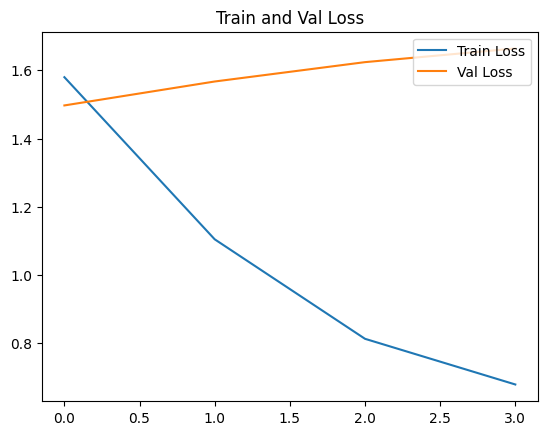

943/943 [==============================] - 1s 1ms/step
mae,rmse: 0.99303882341169 1.2234967223240774


In [30]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()
# 加载最好的训练结果
keras_model.load_weights(model_name)
y_pred = keras_model.predict(X_test_array)
mae = mean_absolute_error(y_test_keras, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_keras, y_pred))
print('mae,rmse:',mae,rmse)

# NCF model base text

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv('rating_review_emb.csv')
display(data.tail(2))

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,user_id,business_id,stars
150853,0.245519,0.124486,-0.084638,-0.093606,0.168214,-0.189911,0.193591,0.426436,-0.009749,-0.30305,...,-0.087216,0.021021,0.066637,-0.198224,0.200206,0.478215,0.336229,68981,2703,1.0
150854,0.128385,0.034232,-0.056932,0.001382,0.159788,-0.171430,0.201015,0.125718,0.051098,-0.34854,...,-0.207604,0.203803,0.053064,-0.275782,-0.149492,0.370956,0.102573,26444,2704,5.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150855 entries, 0 to 150854
Columns: 771 entries, 0 to stars
dtypes: float64(769), int64(2)
memory usage: 887.4 MB


In [7]:
n_users, n_rests, max_rating = data.iloc[:,-3:].max()
min_rating = data.iloc[:,-1].min()
n_factors = 1000

In [8]:
text_embedding_dim = data.iloc[:,0:768].shape[1]

In [9]:
from sklearn.model_selection import train_test_split

# 将数据集分为特征和标签
feature_cols = ['user_id', 'business_id'] + [f'{i}' for i in range(768)]
X = data[feature_cols].values
y = data['stars'].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120684, 770), (30171, 770), (120684,), (30171,))

In [10]:
# 从测试集特征矩阵中分离出用户ID、商户ID和文本嵌入向量

X_train_array = [X_train[:, 0], X_train[:, 1], X_train[:, 2:770]]
X_test_array = [X_test[:, 0], X_test[:, 1], X_test[:, 2:770]]

In [11]:
# 从训练集特征矩阵中分离出用户ID、商户ID和文本嵌入向量
X_train_user_ids = X_train[:, 0]
X_train_business_ids = X_train[:, 1]
X_train_text_embeddings = X_train[:, 2:770]

# 从测试集特征矩阵中分离出用户ID、商户ID和文本嵌入向量
X_test_user_ids = X_test[:, 0]
X_test_business_ids = X_test[:, 1]
X_test_text_embeddings = X_test[:, 2:770]

In [27]:
import tensorflow as tf
from keras.layers import Add, Activation, Lambda, Concatenate, Dense
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding
from keras.optimizers import Adam, Nadam
from keras.regularizers import l2

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors

    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)

        return x

def Recommender(n_users, n_rests, n_factors, min_rating, max_rating, text_embedding_dim):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)

    restaurant = Input(shape=(1,))
    m = EmbeddingLayer(n_rests, n_factors)(restaurant)
    mb = EmbeddingLayer(n_rests, 1)(restaurant)

    text_embedding = Input(shape=(text_embedding_dim,))

    x = Concatenate()([u, text_embedding])
    x = Dense(16, activation='relu')(x)
    x = Dense(n_factors, activation='linear')(x)

    y = Concatenate()([m, text_embedding])
    y = Dense(16, activation='relu')(y)
    y = Dense(n_factors, activation='linear')(y)

    z = Dot(axes=1)([x, y])

    z = Add()([z, ub, mb, text_embedding])
    z = Activation('sigmoid')(z)
    z = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(z)
    output = Dense(1, activation='linear')(z)

    model = Model(inputs=[user, restaurant, text_embedding], outputs=output)
    opt = Nadam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae','mse'])

    return model

In [28]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint, EarlyStopping

# 保存最好的模型
model_name = 'best_model.h5'
es = EarlyStopping(monitor='val_loss', patience=3)
cp = ModelCheckpoint(filepath=model_name, monitor='val_loss', save_best_only=True)

# 构建模型
keras_model = Recommender(int(n_users)+1, int(n_rests)+1, n_factors, min_rating, max_rating, text_embedding_dim)
keras_model.summary()

# 训练模型
history = keras_model.fit([X_train_user_ids, X_train_business_ids, X_train_text_embeddings], y_train,
                          batch_size=64, epochs=150, verbose=1,
                          callbacks=[es, cp],
                          validation_data=([X_test_user_ids, X_test_business_ids, X_test_text_embeddings], y_test))

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_23 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_28 (Embedding)    (None, 1, 1000)              7790200   ['input_22[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_30 (Embedding)    (None, 1, 1000)              2705000   ['input_23[0][0]']      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1886/1886 [==============================] - 74s 37ms/step - loss: 0.6617 - mae: 0.5883 - mse: 0.6498 - val_loss: 0.6832 - val_mae: 0.6368 - val_mse: 0.6595
Epoch 2/150
1886/1886 [==============================] - 74s 39ms/step - loss: 0.4264 - mae: 0.4639 - mse: 0.3958 - val_loss: 0.6482 - val_mae: 0.6193 - val_mse: 0.6108
Epoch 3/150
1886/1886 [==============================] - 75s 40ms/step - loss: 0.3324 - mae: 0.3957 - mse: 0.2945 - val_loss: 0.5877 - val_mae: 0.5439 - val_mse: 0.5478
Epoch 4/150
1886/1886 [==============================] - 64s 34ms/step - loss: 0.2865 - mae: 0.3605 - mse: 0.2478 - val_loss: 0.6000 - val_mae: 0.5351 - val_mse: 0.5608
Epoch 5/150
1886/1886 [==============================] - 75s 40ms/step - loss: 0.2595 - mae: 0.3385 - mse: 0.2227 - val_loss: 0.5846 - val_mae: 0.5242 - val_mse: 0.5477
Epoch 6/150
1886/1886 [==============================] - 64s 34ms/step - loss: 0.2392 - mae: 0.3239 - mse: 0.2050 - val_loss: 0.6192 - val_mae: 0.5449 - val_mse: 0.585

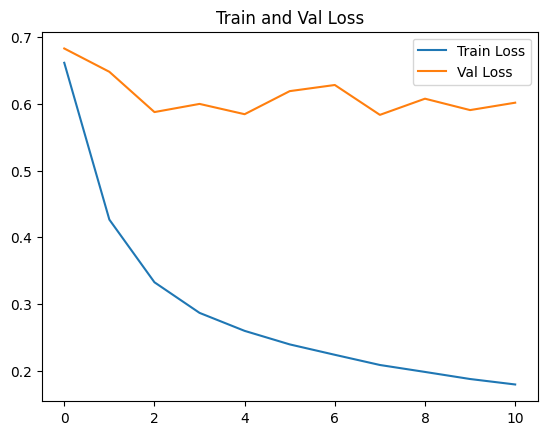

943/943 [==============================] - 2s 2ms/step
mae,rmse: 0.5460859118108189 0.7443390941493762


In [29]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()
# 加载最好的训练结果
keras_model.load_weights(model_name)
y_pred = keras_model.predict(X_test_array)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('mae,rmse:',mae,rmse)